# Child in Need Plan (CiNP) LSOA Analysis


# Importing Necessary Libraries

In [1]:
#import bigquery
from google.cloud import bigquery
from google.cloud import bigquery_storage
 
#other needed libraries
import os
import pandas as pd
import numpy as np
import pandas_gbq
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('tableau-colorblind10')
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')
color='#702A7D'

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/jupyter/.config/gcloud/application_default_credentials.json"

#Instatiate BigQuery Client
client = bigquery.Client()

# Define Query to Get Data

In [3]:
query = """
WITH cinp_WithAddress AS (
  SELECT
    cinp.person_id,
    cinp.StartDate,
    cinp.EndDate,
    cinp.EthnicOrigin,
    p.birth_datetime AS DateOfBirth,
    p.gender_source_value AS Gender,
    a.SOA AS LSOA,
    /* For each cinp row, rank the joined address rows 
       (if any) by DateEventRecorded (converted to DATE) descending */
       
    ROW_NUMBER() OVER (
      PARTITION BY cinp.person_id, cinp.StartDate
      ORDER BY DATE(a.DateEvent) DESC
    ) AS rn
  FROM
    `yhcr-prd-bradfor-bia-core.CB_2649.cb_bmbc_ChildrensSocialServices_CiNP` cinp
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.tbl_AddressHistory_New` a
      ON cinp.person_id = a.person_id
      AND DATE(a.DateEvent) <= cinp.StartDate
  LEFT JOIN
    `yhcr-prd-bradfor-bia-core.CB_2649.person` p
      ON cinp.person_id = p.person_id
)
SELECT 
  person_id,
  Gender,      
  StartDate,
  EndDate,
  EthnicOrigin,
  DateOfBirth,
  LSOA
FROM
  cinp_WithAddress
WHERE 
  rn = 1;
"""

## Load Intervention, Boundary, IMD, and Population Data

In [4]:
# Intervention Data
cinp = pandas_gbq.read_gbq(query)

# Boundary Data
boundary_data_filepath = "../data/BradfordBoundaryData/england_lsoa_2021.shp"
bradord_boundary_data = gpd.read_file(boundary_data_filepath)

# IMD Data
imd_filepath = "../data/English IMD 2019/IMD_2019.shp"
imd_data = gpd.read_file(imd_filepath)

# Population Data
population_data_file_path = '../data/Bradford_Children_population_0-17_2021.csv'
population_data = pd.read_csv(population_data_file_path)

Downloading: 100%|██████████|


In [5]:
import sys
sys.path.append('../code')

from lsoa_analysis_helper import (
    calculate_intervention_rates, 
    plot_intervention_map, 
    plot_cumulative_distribution,
    analyze_imd_relationship
)

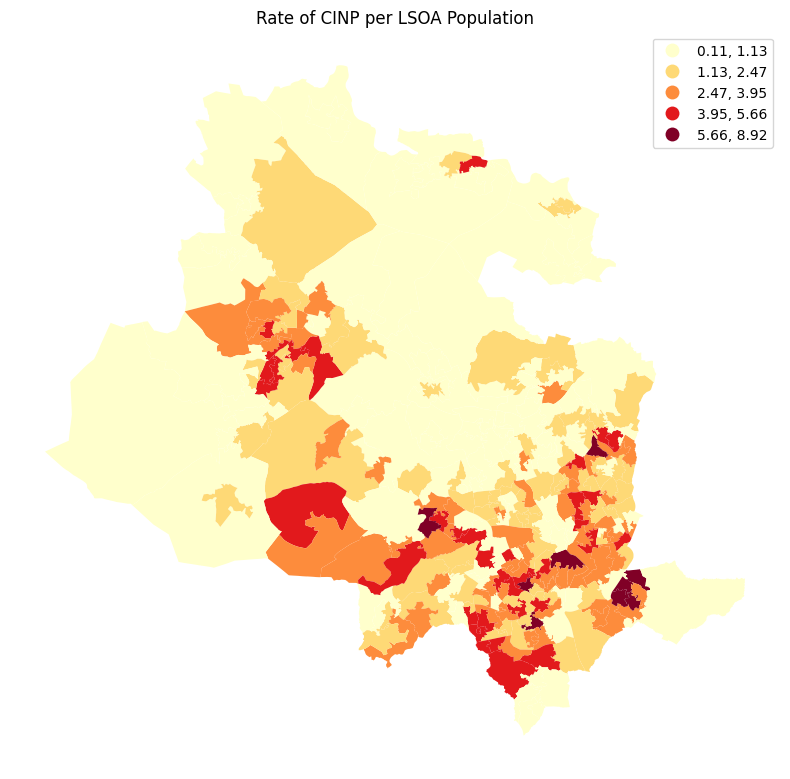

In [6]:
# Calculate intervention rates
cinp = calculate_intervention_rates(
    cinp,
    bradord_boundary_data,
    imd_data,
    population_data,
    intervention_name='CINP'
)

# Plot the intervention rate map
plot_intervention_map(
    cinp,
    intervention_name='CINP'
)

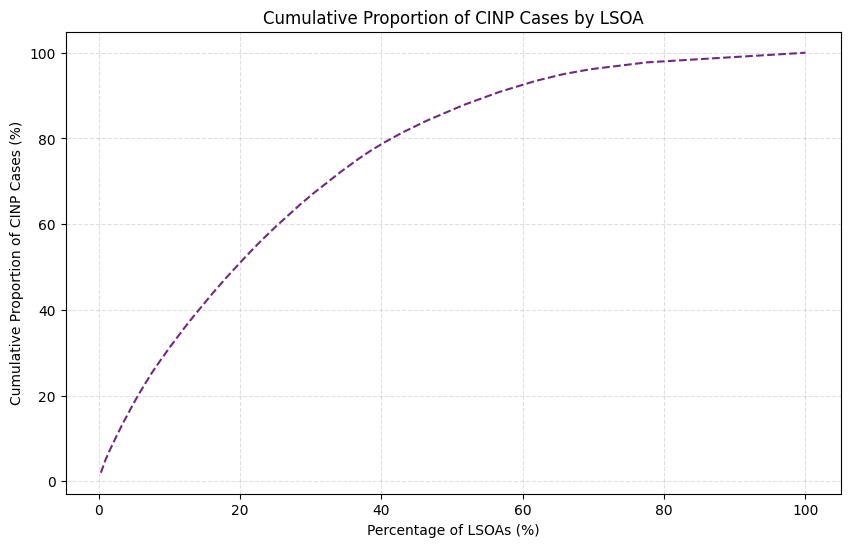

In [7]:
# Cumulative proportion plot
plot_cumulative_distribution(
    cinp,
    intervention_name='CINP'
)

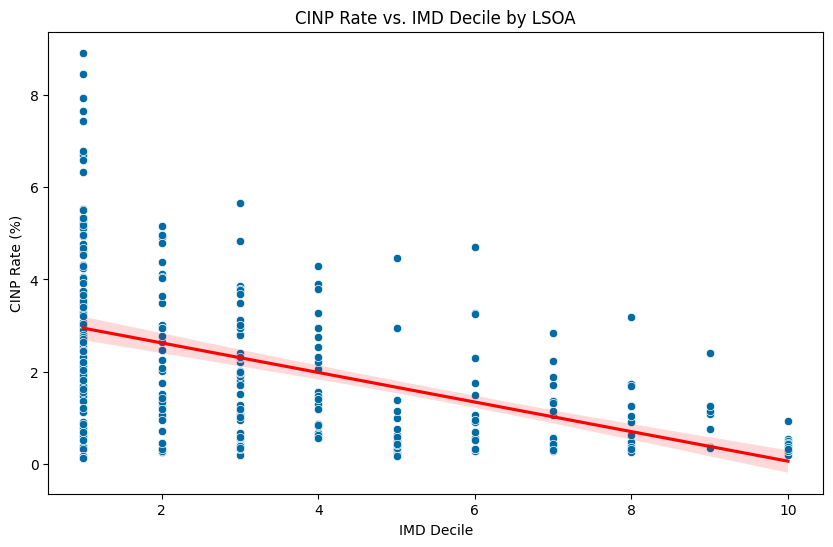


Statistical Analysis Results for CINP:
Pearson Correlation: -0.517 (p-value: 1.983e-22)

Linear Regression Results:
Slope: -0.320741
Intercept: 3.263
R-squared: 0.267
P-value: 1.983e-22


In [8]:
# Intervention rate vs IMD decile relationship
analyze_imd_relationship(
    cinp,
    intervention_name='CINP'
)